# Try false NN methods on chaotic system (coupled Rossler)
## Try with more variables / higher dimension observations

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
import embed_dynamics
# from sklearn.feature_selection import mutual_info_regression
# from scipy.stats import gaussian_kde
# from sklearn.neighbors import KernelDensity
# from sklearn.metrics import mutual_info_score
import sys, importlib
from dynamics_methods import *
from embedding_methods import *
# from scipy.stats import entropy
# from scipy.signal import argrelextrema
# from scipy.signal import find_peaks
from importlib import reload
%load_ext tensorboard

In [129]:
reload(system_dynamics)
reload(embed_dynamics)
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *

In [34]:
t0 = 0
t1 = 100 
dt = 0.01 
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t
]

init_list = [ None, np.array([0.1,0.2,0.3,0,0,15,-20])+np.random.randn(7)*0.2 ]
u_names = ['.']
pred=1

cross_sys = embed_dynamics.CoupledRosslerFullState(t0=t0, tf=t1, dt=dt, pred=pred, params=[0.925, 0.012])
sys_list = [cross_sys]
sys_names = ['Coupled Rossler full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
# A quick and dirty way to add another "test set" that uses longer time
for syst in sys_list:
    syst.add_u_func( u_func_list[0], init_list[0], (t0, t1*3, dt) )
for syst in sys_list:
    syst.data_generator()

u_names=['train0','test1','train_long']
out_names=['S1','S2','S3','S4','S5','S6','S7']

<Figure size 432x288 with 0 Axes>

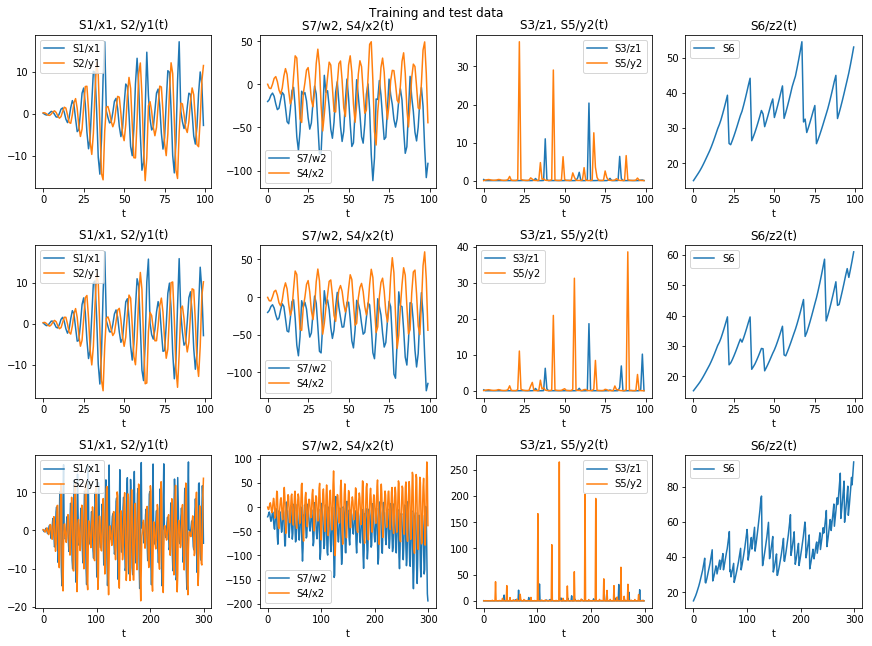

In [35]:
fig,axs = cross_sys.plot_dataset(title='Training and test data', plot_skip_rate=100)

In [162]:
# Test out the chosen delay value. Set up nets.
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_masks = [ [4,7] ] # Reminder: index 0 is time. Index 1 is first state.
Nlayer = 2
Nneuron = 5

net_listF = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
#     sys_list[i].pred = 51
    net_listF.append(
        embed_dynamics.NN_FNN(
            sys_list[i], input_masks[i], ratio=10, stop_threshold=0, max_tau=1000, max_de=10, verbose=True,
            fnn_ind=0, FNNtype='kennel', uniform_delay=False, inverse=True, 
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg
        )
    )
net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]

# Construct models
for nn in net_listF:
    nn.construct()


--- KNN (Kennel 1992) initializing itself ---
At delay = 1, the AMI is 4.726001173479775.
At delay = 2, the AMI is 4.020043708246056.
At delay = 3, the AMI is 3.670513731130128.
At delay = 4, the AMI is 3.4446951301334092.
At delay = 5, the AMI is 3.2755495734087607.
At delay = 6, the AMI is 3.139639039174038.
At delay = 7, the AMI is 3.02773631465368.
At delay = 8, the AMI is 2.9351343534871757.
At delay = 9, the AMI is 2.856676658422775.
At delay = 10, the AMI is 2.788505652708066.
At delay = 11, the AMI is 2.7282864470573163.
At delay = 12, the AMI is 2.6746333138911953.
At delay = 13, the AMI is 2.6242988796762385.
At delay = 14, the AMI is 2.578401975261448.
At delay = 15, the AMI is 2.5331272223763492.
At delay = 16, the AMI is 2.490540563042167.
At delay = 17, the AMI is 2.4489342528684075.
At delay = 18, the AMI is 2.409623819029174.
At delay = 19, the AMI is 2.3729452570608203.
At delay = 20, the AMI is 2.337663562494907.
At delay = 21, the AMI is 2.302457926865179.
At delay =

In [163]:
# Train models. 
Epoch = 200
for nn in net_listF:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Inputset size = (9808, 4, 1); outputset size = (9808, 7, 1)
Input set is masked by  [4, 7]
Train on 9808 samples
Epoch 1/200
9808/9808 [==============================] - 1s 72us/sample - loss: 568.6603
Epoch 2/200
9808/9808 [==============================] - 0s 32us/sample - loss: 526.9454
Epoch 3/200
9808/9808 [==============================] - 0s 34us/sample - loss: 491.2739
Epoch 4/200
9808/9808 [==============================] - 0s 37us/sample - loss: 460.4765
Epoch 5/200
9808/9808 [==============================] - 0s 30us/sample - loss: 433.5436
Epoch 6/200
9808/9808 [==============================] - 0s 31us/sample - loss: 408.4113
Epoch 7/200
9808/9808 [==============================] - 0s 33us/sample - loss: 386.4370
Epoch 8/200
9808/9808 [==============================] - 0s 30us/sample - loss: 366.9910
Epoch 9/200
9808/9808 [==============================] - 0s 32us/sample - loss: 349.4964
Epoch 10/200
9808/9808 [==============================] - 0s 32us/sample - loss: 333.7

In [4]:
# Plotting helper function...
# This one is modified to suite FNN. Don't remove it too soon. 
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title=''):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (max(15,Ncol*4),Nrow*3), squeeze=False)
#     figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = np.squeeze(results_list[nn][3][jj])
#             time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
#                 print(time_series)
#                 print(result.shape)
#                 print(n, i, n + len(net_inds)*i, j)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
                # Also draw this network's plot onto the overlay plots over all networks
#                 axst[i][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
        
#         for i in range(Noutput):
#             axst[i][j].set_title( datatype+' of '+out_names[i]+'\n on input '+u_names[jj] )
#             axst[i][j].legend(net_names)
            
    fig.suptitle(title)
#     figt.suptitle('Overlaying result for '+title)
    return fig, axs

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1):
    axs.plot(time[::skip], data[::skip])
#     print(time.shape, data2.shape)
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[::skip], data2[::skip])
        axs.legend(leglist)
    return axs

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

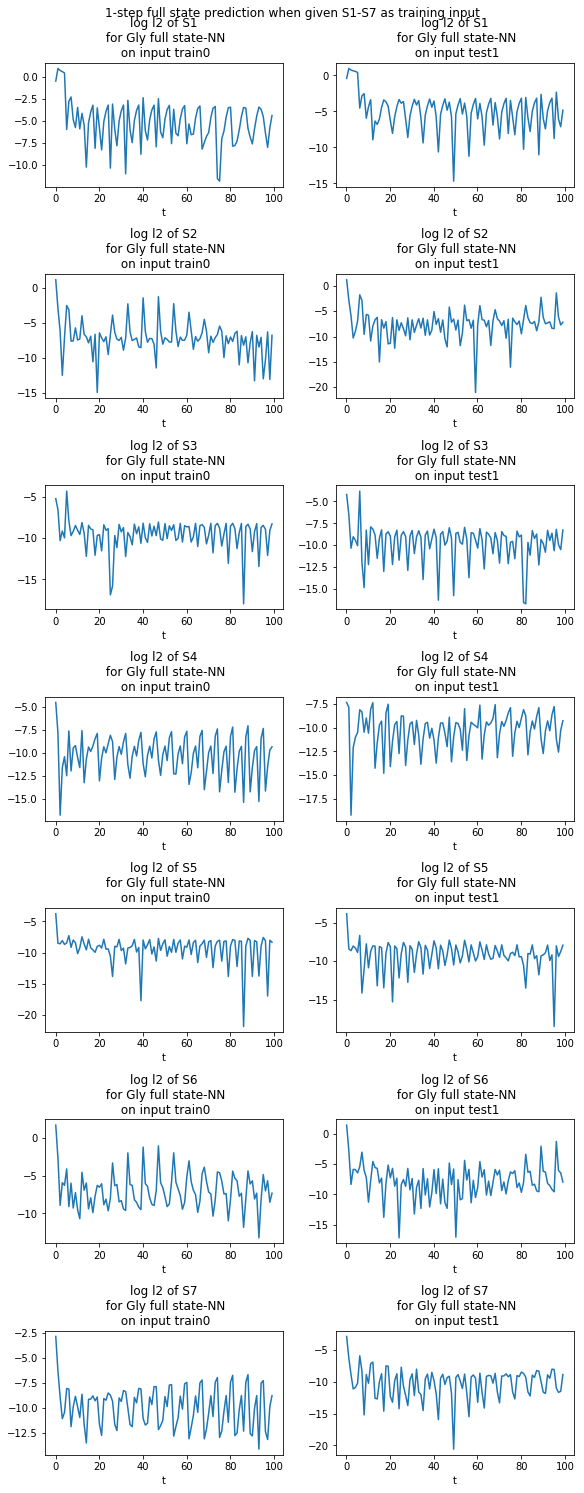

In [37]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S7 as training input\n' )

Dimensions: Outputset = (9808, 7, 1), results = (9808, 7, 1)


<Figure size 432x288 with 0 Axes>

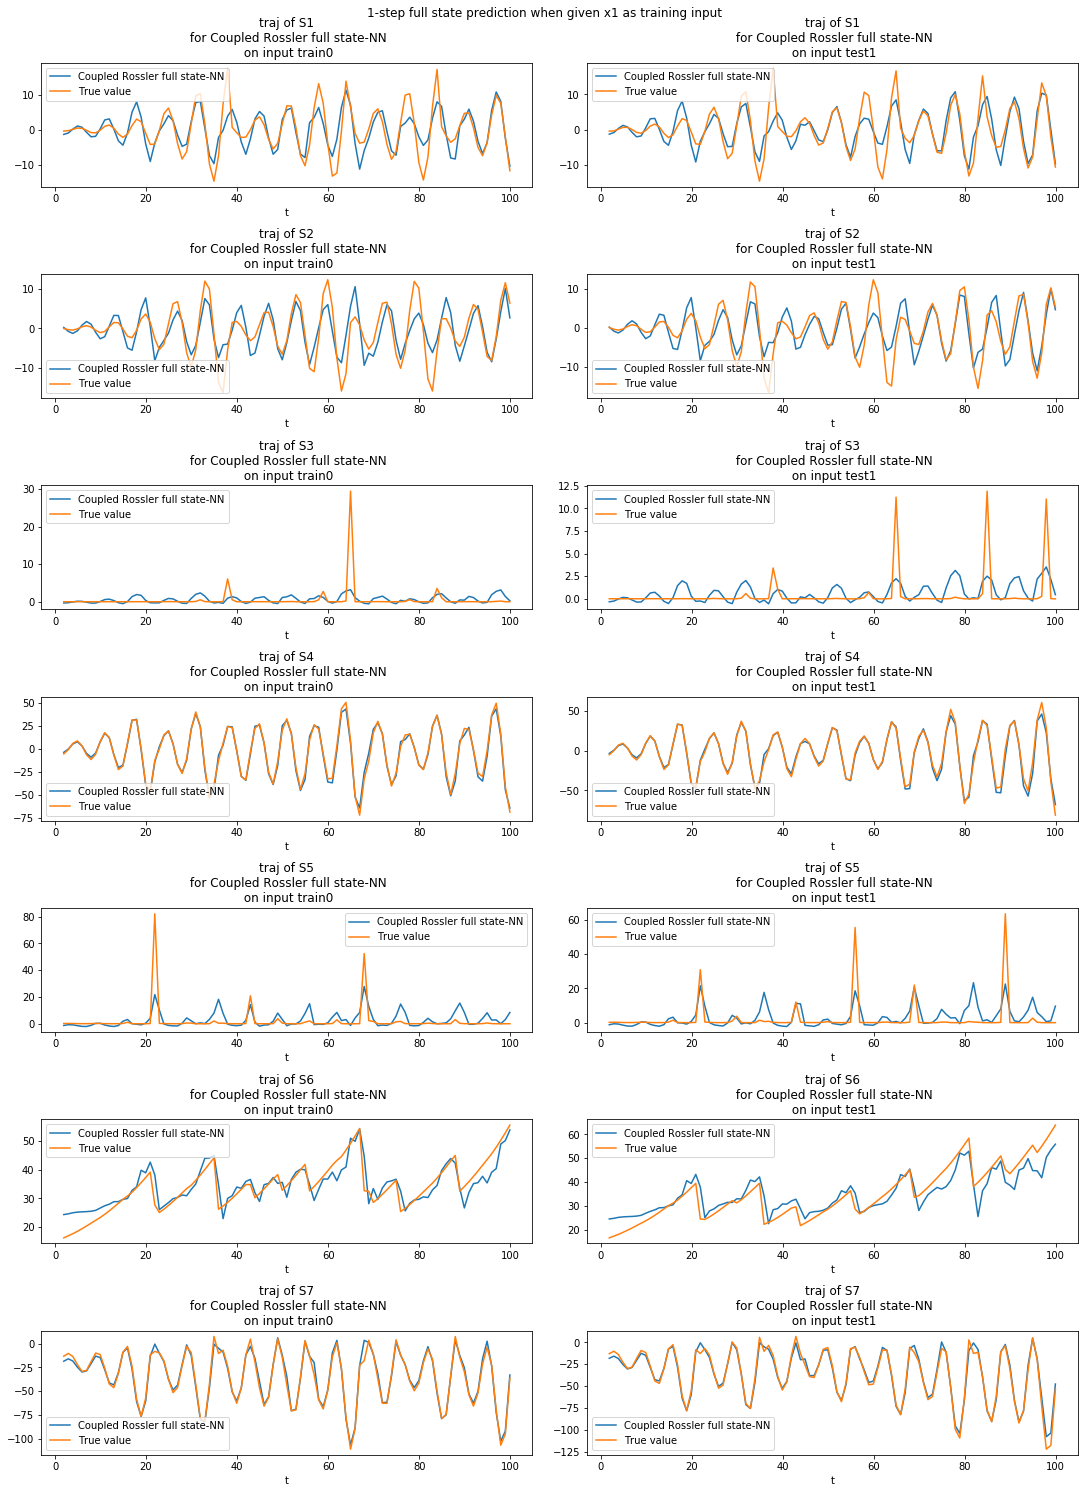

In [165]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given x1 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

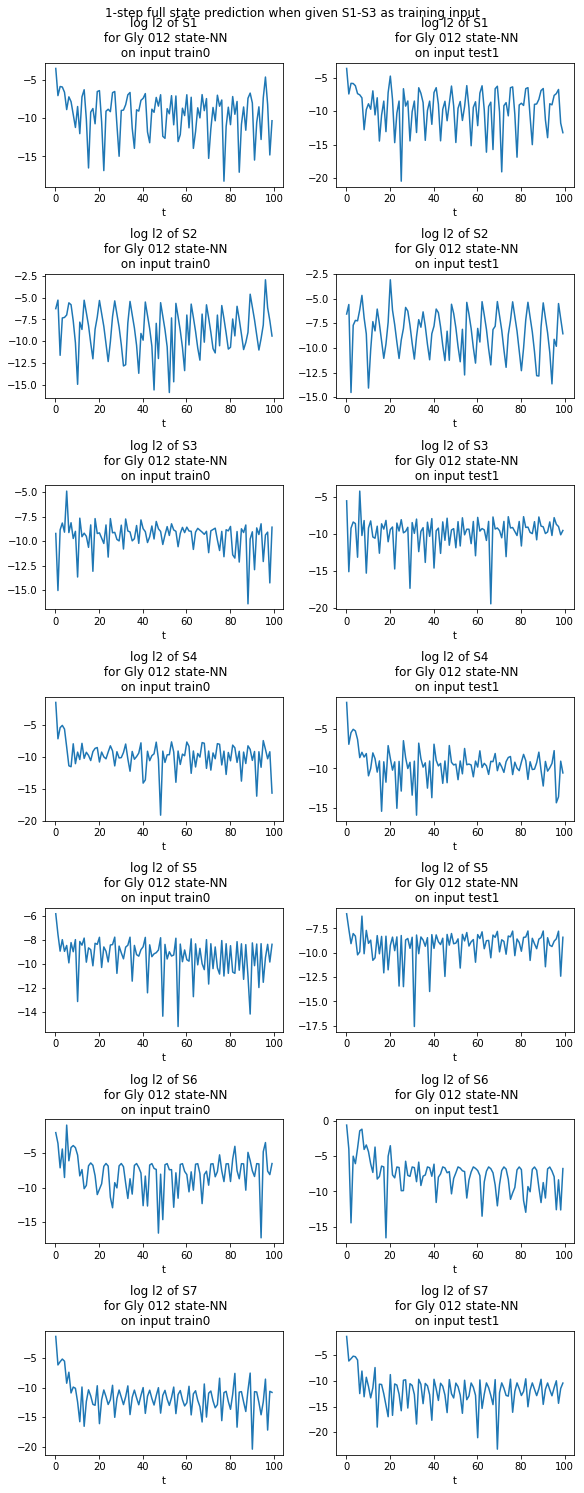

In [34]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

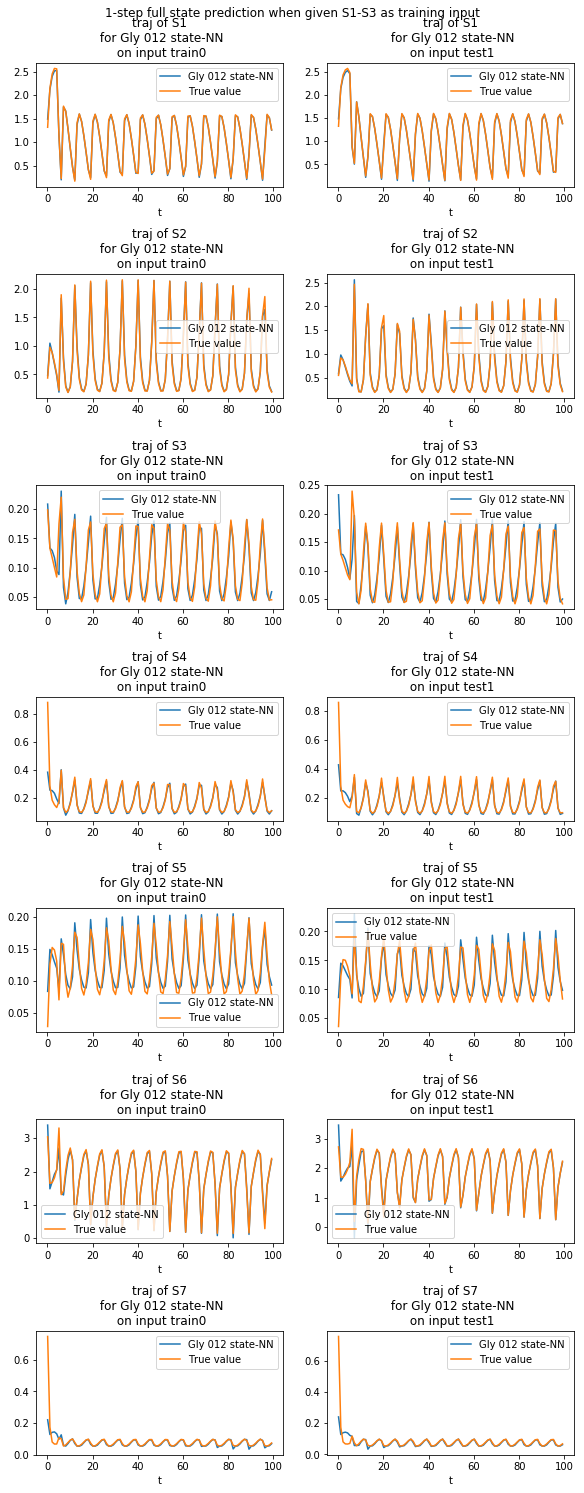

In [35]:
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )

Dimensions: Outputset = (9808, 7, 1), results = (9808, 7, 1)


<Figure size 432x288 with 0 Axes>

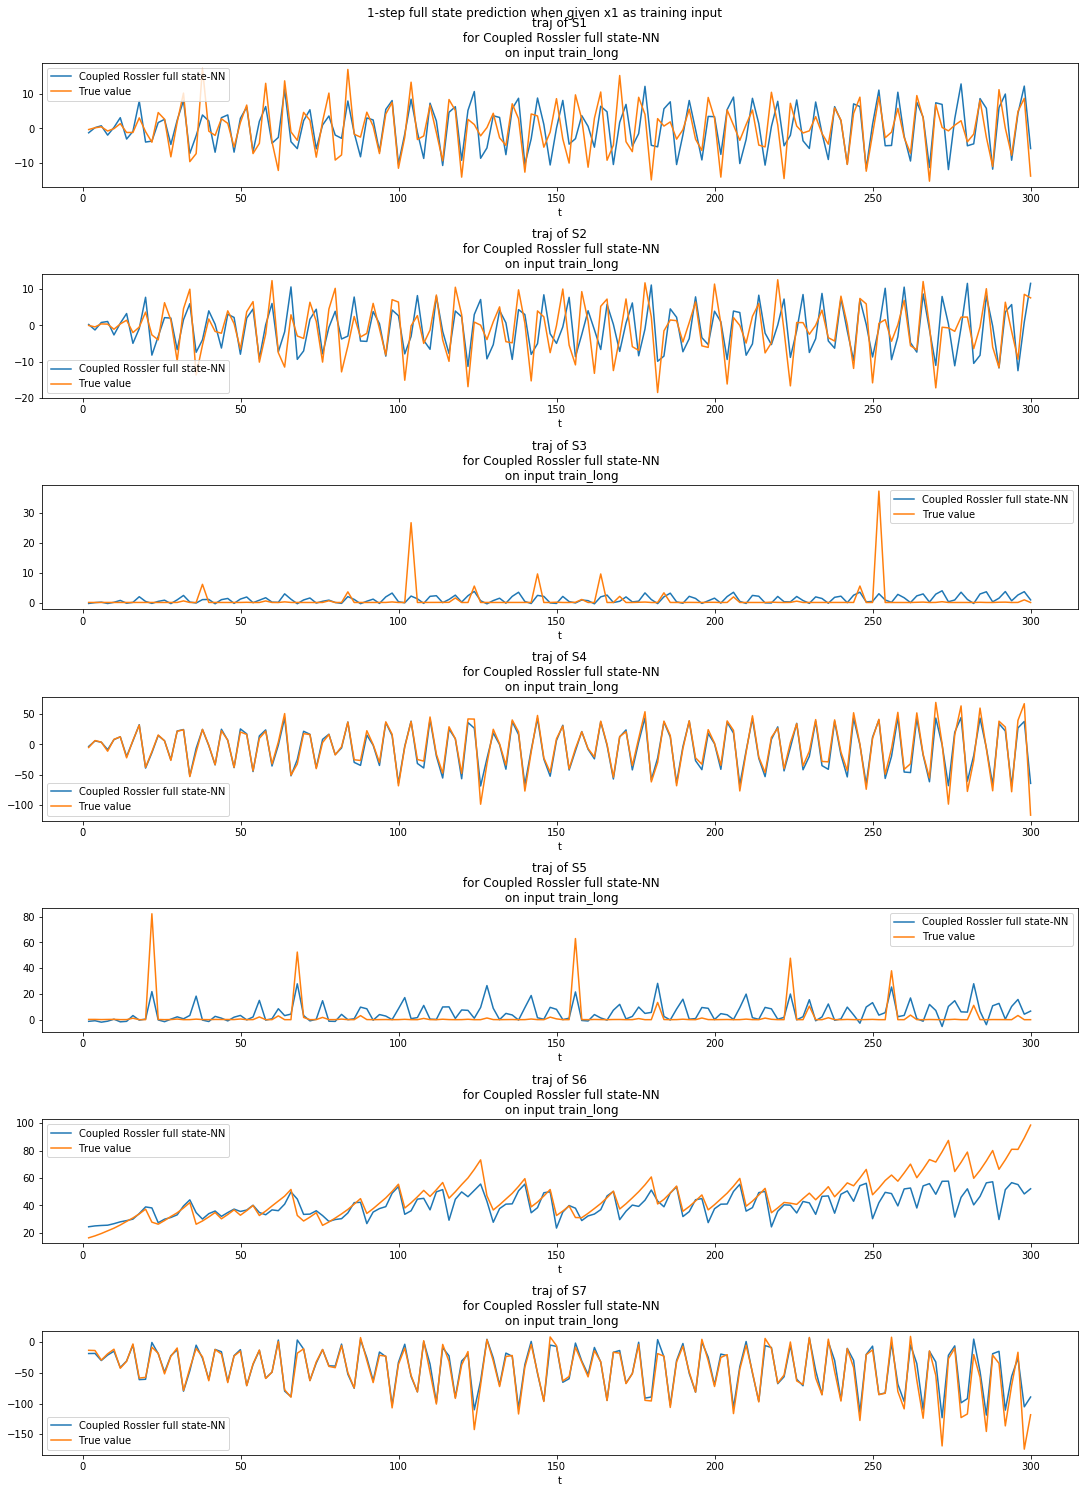

In [164]:
# Plots the test dataset with very long time range
fig, axs = plot_tests( test_inds=[2], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=200, 
                       title='1-step full state prediction when given x1 as training input\n' )
# fig, axs = plot_tests( test_inds=[2], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
#                        net_names=net_names, u_names=u_names, out_names=out_names,
#                        datatype='l2', log_mode=True, plot_skip_rate=500, 
#                        title='1-step full state prediction when given S1-S3 as training input\n' )

## Test embedding methods

In [107]:
importlib.reload(sys.modules["embedding_methods"])
importlib.reload(sys.modules["embed_dynamics"])
# importlib.reload(sys.modules["system_dynamics"])
from embedding_methods import *
from embed_dynamics import *
X = cross_sys.Inputset[0][1:8]

In [81]:
# Single-variable MI methods to find their best delays
find_delay(X[0], method='mi', MImethod='KL total', min_delay=1, max_delay=700, max_dim=10, 
           end_early=True, verbose=False, pairwise=False, 
           uniform_delay=True, init_i=0, Nbin=50, ep=1e-10)

---Ending AMI/MMI local min now---


(159, True)

In [137]:
# Single-variable methods to find best delay dimension
for i in range(7):
    results = find_delay_by_FNN(X[[i]], method='kennel', ratio=10, pred=1, stop_threshold=0, 
                      min_tau=100, max_tau=7000, max_dim=10, uniform_delay=False, 
                      end_early=True, verbose=False,
                      inverse=True, local_max=False, twoD=False)
    print(results)

---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
We've exhausted the allowed dimension limit. Exiting now.
([0, 0], [0, 119, 121], array([[119, 121,   0,   0,   0,   0,   0,   0,   0,   0]]))


In [110]:
# Multi-variable methods to find best delay dimension
o = 3
for i in range(7):
    if i == o:
        continue
    results = find_delay_by_FNN(X[[o,i]], method='kennel', ratio=10, pred=51, stop_threshold=0, 
                      min_tau=100, max_tau=7000, max_dim=10, uniform_delay=False, 
                      end_early=True, verbose=False,
                      inverse=True, local_max=False, twoD=False)
    print(results)

---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
We've exhausted the allowed dimension limit. Exiting now.
([1, 0], [0, 159, 138], array([[138,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [159,   0,   0,   0,   0,   0,   0,   0,   0,   0]]))
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min now---
---Ending AMI/MMI local min 

In [37]:
# Briefly test out the FNN method.
find_delay_by_FNN_Garcia(X[[0,3]], ratio=10, pred=1, stop_threshold=0, min_tau=1, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True)

Starting the 1-th embedding cycle
At delay=-1 using j=0 for de=0: average d1 = 0.18722664668354094; average d2 = 0.18648164214222226
0 out of 9998 samples counted as false neighbors
At delay=-1 using j=1 for de=0: average d1 = 0.2474540307619737; average d2 = 0.24595182208796634
0 out of 9998 samples counted as false neighbors
At delay=-2 using j=0 for de=0: average d1 = 0.19388116338016895; average d2 = 0.19005009048352928
0 out of 9997 samples counted as false neighbors
At delay=-2 using j=1 for de=0: average d1 = 0.26174150806647184; average d2 = 0.25534543365735474
0 out of 9997 samples counted as false neighbors
At delay=-3 using j=0 for de=0: average d1 = 0.1990696674058772; average d2 = 0.19569026291540428
0 out of 9996 samples counted as false neighbors
At delay=-3 using j=1 for de=0: average d1 = 0.2707570995192026; average d2 = 0.26535360672216196
0 out of 9996 samples counted as false neighbors
At delay=-4 using j=0 for de=0: average d1 = 0.20294759320142491; average d2 = 0.

([], [], [])

Cao et al. 1998

In [67]:
find_delay_by_FNN_Cao( X[[0,3]], pred=1, min_tau=100, max_tau=700, max_dim=10, 
                              init_i=0, end_early=True, verbose=True )

--- KNN (Cao 1998) initializing itself ---
At delay = 100, the AMI is 1.8722479360695834.
At delay = 101, the AMI is 1.8702202601677484.
At delay = 102, the AMI is 1.8671303262516838.
At delay = 103, the AMI is 1.8635129832958715.
At delay = 104, the AMI is 1.8594762880585334.
At delay = 105, the AMI is 1.854016777783058.
At delay = 106, the AMI is 1.8471643728388774.
At delay = 107, the AMI is 1.8410590782200638.
At delay = 108, the AMI is 1.8364084255359856.
At delay = 109, the AMI is 1.8322062616754993.
At delay = 110, the AMI is 1.8279112971665121.
At delay = 111, the AMI is 1.8230862429570918.
At delay = 112, the AMI is 1.8183146545611075.
At delay = 113, the AMI is 1.813808494520682.
At delay = 114, the AMI is 1.8093336763512458.
At delay = 115, the AMI is 1.8055551710292086.
At delay = 116, the AMI is 1.801577212804741.
At delay = 117, the AMI is 1.7982789433896427.
At delay = 118, the AMI is 1.7947072043876888.
At delay = 119, the AMI is 1.7916885783272445.
At delay = 120, the 

([0], [0, 159], array([[159,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]))

Test out other non-FNN information-theory-related methods

In [59]:
# total correlation - this one can't run on full states, because the computation grows exponentially. 
# iterate_for_local_min(X[:4], method='KL', pairwise=False, end_early=False, verbose=True) <-- won't work
iterate_for_local_min(X[[0,3]], method='KL', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 5.562811483990516.
At delay = 2, the AMI is 5.54764622531849.
At delay = 3, the AMI is 5.523116768383609.
At delay = 4, the AMI is 5.490279469538275.
At delay = 5, the AMI is 5.450296980036784.
At delay = 6, the AMI is 5.404314086440729.
At delay = 7, the AMI is 5.353434354720502.
At delay = 8, the AMI is 5.298723379707743.
At delay = 9, the AMI is 5.241169076075467.
At delay = 10, the AMI is 5.181614199397161.
At delay = 11, the AMI is 5.120727381293389.
At delay = 12, the AMI is 5.059032952679287.
At delay = 13, the AMI is 4.996961332015655.
At delay = 14, the AMI is 4.934882132391851.
At delay = 15, the AMI is 4.8731094932041294.
At delay = 16, the AMI is 4.811880793114931.
At delay = 17, the AMI is 4.7513242676297285.
At delay = 18, the AMI is 4.6914684214895965.
At delay = 19, the AMI is 4.6323055227955.
At delay = 20, the AMI is 4.573865989834724.
---AMI/MMI didn't find a local minimum within 20 delays


(20, False)

In [98]:
# KL divergence - this one can't run on full states, because the computation grows exponentially. 
# This is different from the one above. This one treats X and delayed X as total, separate distributions.
# iterate_for_local_min(X[2:4], method='total divergence', pairwise=False, end_early=False, verbose=True) #<-- won't work
iterate_for_local_min(X[:4], max_iter=50, method='total divergence', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 7400.95969591008.
At delay = 2, the AMI is 7646.693350129048.
1 is the optimal delay it found.
At delay = 3, the AMI is 7810.49072604935.
1 is the optimal delay it found.
At delay = 4, the AMI is 7916.009230712002.
1 is the optimal delay it found.
At delay = 5, the AMI is 7982.550869083535.
1 is the optimal delay it found.
At delay = 6, the AMI is 8014.734157127564.
1 is the optimal delay it found.
At delay = 7, the AMI is 8020.047377212842.
1 is the optimal delay it found.
At delay = 8, the AMI is 8023.92458414709.
1 is the optimal delay it found.
At delay = 9, the AMI is 8029.138000487235.
1 is the optimal delay it found.
At delay = 10, the AMI is 8035.7161119354405.
1 is the optimal delay it found.
At delay = 11, the AMI is 8043.74611174388.
1 is the optimal delay it found.
At delay = 12, the AMI is 8053.350512546836.
1 is the optimal delay it found.
At delay = 13, the AMI is 8064.745792036801.
1 is the optimal delay it found.
At delay = 14, the AMI is 8078.

(1, True)

In [110]:
# interaction information - this one can't run on full states, because the computation grows exponentially. 
# I don't know if it'll even make sense to run this pairwisely, but here it goes...
iterate_for_local_min(X[2:6], method='interaction', pairwise=True, end_early=False, verbose=True)

At delay = 1, the AMI is 81.93562032278018.
At delay = 2, the AMI is 85.84714630428755.
1 is the optimal delay it found.
At delay = 3, the AMI is 86.58523818756656.
1 is the optimal delay it found.
At delay = 4, the AMI is 87.21022341459096.
1 is the optimal delay it found.
At delay = 5, the AMI is 87.75960902465191.
1 is the optimal delay it found.
At delay = 6, the AMI is 88.1881203547498.
1 is the optimal delay it found.
At delay = 7, the AMI is 88.25386678550173.
1 is the optimal delay it found.
At delay = 8, the AMI is 88.25676554051363.
1 is the optimal delay it found.
At delay = 9, the AMI is 88.288981153313.
1 is the optimal delay it found.
At delay = 10, the AMI is 88.31847552546584.
1 is the optimal delay it found.
At delay = 11, the AMI is 88.33785852831387.
1 is the optimal delay it found.
At delay = 12, the AMI is 88.35930135333946.
1 is the optimal delay it found.
At delay = 13, the AMI is 88.39702322682048.
1 is the optimal delay it found.
At delay = 14, the AMI is 88.44

(1, True)

In [62]:
# Distance-to-Diagonal, non-pairwise (it doesn't make sense to use pairwise)
iterate_for_local_min(X[[0,3]], method='DD', max_iter=100, pairwise=False, end_early=False, verbose=True)

At delay = 1, the AMI is -0.6698160266871748.
At delay = 2, the AMI is -2.6793548320708154.
At delay = 3, the AMI is -6.02710257050883.
At delay = 4, the AMI is -10.709393020730488.
At delay = 5, the AMI is -16.720505845261396.
At delay = 6, the AMI is -24.052787874985782.
At delay = 7, the AMI is -32.69677627933456.
At delay = 8, the AMI is -42.64131111791245.
At delay = 9, the AMI is -53.873631691956625.
At delay = 10, the AMI is -66.37945559561177.
At delay = 11, the AMI is -80.14304196424314.
At delay = 12, the AMI is -95.14724176916963.
At delay = 13, the AMI is -111.37353855241587.
At delay = 14, the AMI is -128.80208301489867.
At delay = 15, the AMI is -147.41172456809346.
At delay = 16, the AMI is -167.18004248255767.
At delay = 17, the AMI is -188.08337872522802.
At delay = 18, the AMI is -210.0968740485586.
At delay = 19, the AMI is -233.19450841400658.
At delay = 20, the AMI is -257.34914641045935.
At delay = 21, the AMI is -282.53258801713366.
At delay = 22, the AMI is -308

(100, False)

In [63]:
# Average Displacement, non-pairwise (it doesn't make sense to use pairwise)
iterate_for_local_min(X[[0,3]], method='AD', max_iter=100, pairwise=False, end_early=False, verbose=True)

At delay = 1, the AMI is 2.186472643718121.
At delay = 2, the AMI is 4.37378465459328.
1 is the optimal delay it found.
At delay = 3, the AMI is 6.561373761634772.
1 is the optimal delay it found.
At delay = 4, the AMI is 8.748557532914363.
1 is the optimal delay it found.
At delay = 5, the AMI is 10.934551831213053.
1 is the optimal delay it found.
At delay = 6, the AMI is 13.118518678700122.
1 is the optimal delay it found.
At delay = 7, the AMI is 15.29960858520562.
1 is the optimal delay it found.
At delay = 8, the AMI is 17.476974847746018.
1 is the optimal delay it found.
At delay = 9, the AMI is 19.64978540036597.
1 is the optimal delay it found.
At delay = 10, the AMI is 21.817219711139085.
1 is the optimal delay it found.
At delay = 11, the AMI is 23.97847620661399.
1 is the optimal delay it found.
At delay = 12, the AMI is 26.13276555890725.
1 is the optimal delay it found.
At delay = 13, the AMI is 28.279318672104043.
1 is the optimal delay it found.
At delay = 14, the AMI i

(1, True)

In [134]:
# Garcia with 1D local minimum criterion
find_delay_by_FNN_Garcia(X, ratio=1.15, pred=1, stop_threshold=0, max_tau=30, max_dim=10,
                         init_i=0, end_early=True, verbose=True, inverse=False, twoD=False)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.00549200836413464; average d2 = 0.005510719535773712
105 out of 9968 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.005554402073790368; average d2 = 0.005590145396559451
202 out of 9968 samples counted as false neighbors
At delay=1 using j=2 for de=0: average d1 = 0.00497337873546979; average d2 = 0.004971145244520707
0 out of 9968 samples counted as false neighbors
At delay=1 using j=3 for de=0: average d1 = 0.004986676367662435; average d2 = 0.004984659415266209
0 out of 9968 samples counted as false neighbors
At delay=1 using j=4 for de=0: average d1 = 0.004961302183558986; average d2 = 0.00495867234350822
0 out of 9968 samples counted as false neighbors
At delay=1 using j=5 for de=0: average d1 = 0.0058340755977996225; average d2 = 0.005920188323607222
257 out of 9968 samples counted as false neighbors
At delay=1 using j=6 for de=0: average d1 = 0.004964788589108723; av

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0.010533707865168539,
  0.016755292465134946,
  0.020770620108368453,
  0.02388359257400903,
  0.025592131674026495,
  0.027802870621298804,
  0.029712909054406746,
  0.03142254793695412,
  0.03293172690763052,
  0.033738327141279244])

In [48]:
# Garcia with 1D local MAXimum criterion
find_delay_by_FNN_Garcia(X[[0,3]], ratio=1.15, pred=1, stop_threshold=0, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True, local_max=True, inverse=False, twoD=False)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.1877903592147608; average d2 = 0.1980978858975014
1380 out of 9998 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.24746362728744356; average d2 = 0.2820536263645115
1878 out of 9998 samples counted as false neighbors
At delay=2 using j=0 for de=0: average d1 = 0.19431201583048624; average d2 = 0.20159265082671868
1161 out of 9997 samples counted as false neighbors
At delay=2 using j=1 for de=0: average d1 = 0.2620835982731542; average d2 = 0.2754435374346363
1217 out of 9997 samples counted as false neighbors
At delay=3 using j=0 for de=0: average d1 = 0.1994006903504173; average d2 = 0.20481866617999167
905 out of 9996 samples counted as false neighbors
At delay=3 using j=1 for de=0: average d1 = 0.2711691686444017; average d2 = 0.27962187204082034
863 out of 9996 samples counted as false neighbors
At delay=4 using j=0 for de=0: average d1 = 0.20342943167514096; average d2

([1, 1, 0, 1, 0],
 [12, 4, 1, 2, 1],
 [0.0019024732151797336,
  0.0013022137633977762,
  0.00030054097375275494,
  0.0003006012024048096,
  0.0001002104419280489])

In [49]:
# Garcia with 1D local maximum and backwards embedding
find_delay_by_FNN_Garcia(X[[0,6]], ratio=1.02, pred=1, stop_threshold=0, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True, local_max=True, inverse=True, twoD=False)

Starting the 1-th embedding cycle
At delay=-1 using j=0 for de=0: average d1 = 0.20736418655025643; average d2 = 0.20664263129339097
1112 out of 9998 samples counted as false neighbors
At delay=-1 using j=1 for de=0: average d1 = 0.26449253445529514; average d2 = 0.2619442065124623
1810 out of 9998 samples counted as false neighbors
At delay=-2 using j=0 for de=0: average d1 = 0.21111425909136264; average d2 = 0.208798964686164
832 out of 9997 samples counted as false neighbors
At delay=-2 using j=1 for de=0: average d1 = 0.28358742210860594; average d2 = 0.27358951781830926
945 out of 9997 samples counted as false neighbors
At delay=-3 using j=0 for de=0: average d1 = 0.21462628887646945; average d2 = 0.21214898973165525
596 out of 9996 samples counted as false neighbors
At delay=-3 using j=1 for de=0: average d1 = 0.2979674490436058; average d2 = 0.2887369673932037
625 out of 9996 samples counted as false neighbors
At delay=-4 using j=0 for de=0: average d1 = 0.2176106009683497; aver

([1], [17], [0.01021839310759367])

In [53]:
importlib.reload(sys.modules["embedding_methods"])
importlib.reload(sys.modules["embed_dynamics"])
# importlib.reload(sys.modules["system_dynamics"])
from embedding_methods import *
from embed_dynamics import *
X = cross_sys.Inputset[0][1:8]

In [56]:
# Kennel "original" method
find_delay_by_FNN_Kennel(X[[0,6]], ratio=1.01, pred=1, stop_threshold=0.001, min_tau=1, max_tau=200, max_dim=10, 
                         uniform_delay=False, init_i=0, end_early=True, inverse=True, verbose=True)

--- KNN (Kennel 1992) initializing itself ---
At delay = 1, the AMI is 4.756880817874918.
At delay = 2, the AMI is 4.074320831641973.
At delay = 3, the AMI is 3.7892486624929096.
At delay = 4, the AMI is 3.6145309690295178.
At delay = 5, the AMI is 3.489796470079162.
At delay = 6, the AMI is 3.3958902997452305.
At delay = 7, the AMI is 3.319330903134809.
At delay = 8, the AMI is 3.2527910999021783.
At delay = 9, the AMI is 3.189059116278764.
At delay = 10, the AMI is 3.1290350704378067.
At delay = 11, the AMI is 3.071523387208304.
At delay = 12, the AMI is 3.0177310127509207.
At delay = 13, the AMI is 2.967831397157079.
At delay = 14, the AMI is 2.9221214351903866.
At delay = 15, the AMI is 2.878147560573936.
At delay = 16, the AMI is 2.837244972422458.
At delay = 17, the AMI is 2.798428686411416.
At delay = 18, the AMI is 2.7629003233816842.
At delay = 19, the AMI is 2.7287014716951044.
At delay = 20, the AMI is 2.697518098034352.
At delay = 21, the AMI is 2.6687074831333293.
At delay

([0], [0, 159], array([[159,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]))